In [1]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet 
from utils import getHRGroups, getHRsForTimePeriods, graphMultiHRDate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fitbitHRDf = getWorkingHRDfParquet('fitbit')

Text(0.5, 0, 'BPM')

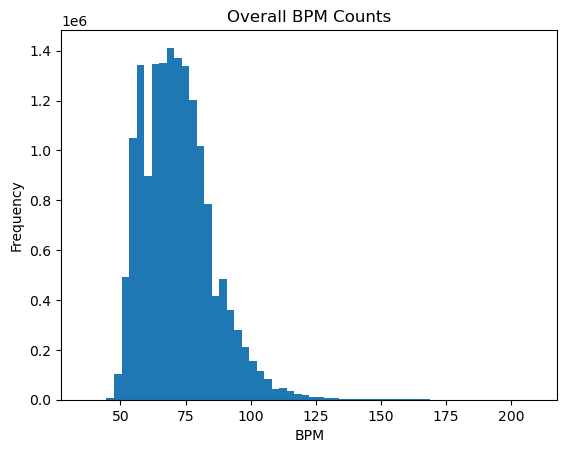

In [3]:
ax = fitbitHRDf.value.plot.hist(bins=60, title="Overall BPM Counts")
ax.set_xlabel("BPM")

In [4]:
fitbitHRDf = fitbitHRDf.sort_index()
timesSeries = pd.Series(fitbitHRDf.index)
betweenMesures = ((timesSeries.shift(-1) - timesSeries)).dt.total_seconds()
betweenMesures

0           15.0
1           10.0
2            5.0
3            5.0
4            5.0
            ... 
16052780     5.0
16052781     5.0
16052782    10.0
16052783     5.0
16052784     NaN
Name: sampleDT, Length: 16052785, dtype: float64

In [5]:
fitbitHRDf["timeToNextReading"] = pd.Series(index=fitbitHRDf.index, data=betweenMesures.values)
fitbitHRDf = fitbitHRDf.dropna()
fitbitHRDf

,value,timeToNextReading
sampleDT,,
2020-05-13 10:02:19-07:00,70,15.0
2020-05-13 10:02:34-07:00,70,10.0
2020-05-13 10:02:44-07:00,79,5.0
2020-05-13 10:02:49-07:00,80,5.0
2020-05-13 10:02:54-07:00,79,5.0
...,...,...
2024-09-17 12:51:50-07:00,61,5.0
2024-09-17 12:51:55-07:00,62,5.0
2024-09-17 12:52:00-07:00,64,5.0


In [6]:
fitbitHRDf["timeToNextReading"].describe()

count    1.605278e+07
mean     8.547639e+00
std      6.527544e+02
min      1.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      2.060050e+06
Name: timeToNextReading, dtype: float64

Text(0.5, 0, 'Interval (sec)')

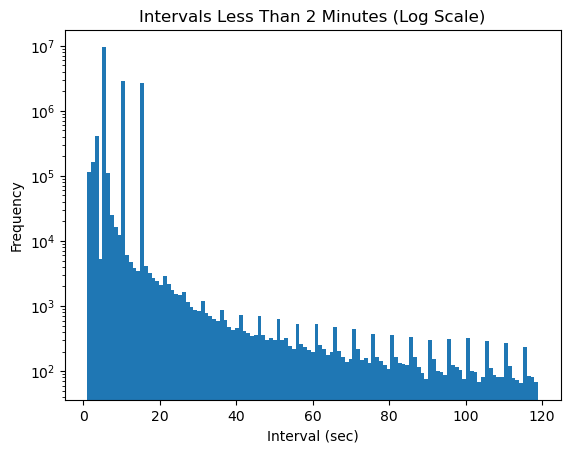

In [7]:
ax = betweenMesures.loc[betweenMesures<120].plot.hist(bins=119, log=True, title="Intervals Less Than 2 Minutes (Log Scale)")
ax.set_xlabel("Interval (sec)")


Text(0.5, 0, 'Interval (sec)')

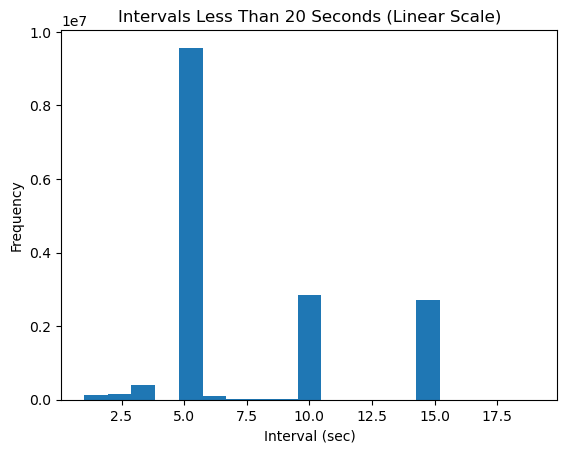

In [8]:
ax = betweenMesures.loc[betweenMesures<20].plot.hist(bins=19, title="Intervals Less Than 20 Seconds (Linear Scale)")
ax.set_xlabel("Interval (sec)")


In [25]:
from collections import OrderedDict
import math
def miniHistograms(od, ylabel):
    vGraphNum = math.ceil(len(od)/4)
    fig, axs = plt.subplots(vGraphNum, 4, figsize=(16, vGraphNum * 5))
    for rowNum in range(vGraphNum):
        for colNum in range(4):
            if (4*rowNum) + colNum >= len(od.keys()):
                continue
            odKey = list(od.keys())[(4*rowNum) + colNum]
            axs[rowNum, colNum].set_title(odKey)
            axs[rowNum, colNum].set_ylabel(ylabel)
            axs[rowNum, colNum].hist(od[odKey], log=True)

    plt.tight_layout()
    plt.show()

In [13]:
# do an analysis on the group lengths based on maxinterval
# for all the analysis the min interval length will be 1 second < make sure grouping code works with two sample groups
# as max interval changes from 1 - 40
# one plot with the average interval length
minGroupTime = pd.Timedelta(seconds=1)

dataod = OrderedDict()
for maxDelta in range(1,40+1):
    hrGroups = getHRGroups(fitbitHRDf, maxDelta, minGroupTime)
    hrGroupDurations = [(g[1]-g[0]).total_seconds() for g in hrGroups]
    dataod[maxDelta] = hrGroupDurations
    print(f"generated {len(dataod)} groups")

generated 1 groups
generated 2 groups
generated 3 groups
generated 4 groups
generated 5 groups
generated 6 groups
generated 7 groups
generated 8 groups
generated 9 groups
generated 10 groups
generated 11 groups
generated 12 groups
generated 13 groups
generated 14 groups
generated 15 groups
generated 16 groups
generated 17 groups
generated 18 groups
generated 19 groups
generated 20 groups
generated 21 groups
generated 22 groups
generated 23 groups
generated 24 groups
generated 25 groups
generated 26 groups
generated 27 groups
generated 28 groups
generated 29 groups
generated 30 groups
generated 31 groups
generated 32 groups
generated 33 groups
generated 34 groups
generated 35 groups
generated 36 groups
generated 37 groups
generated 38 groups
generated 39 groups


KeyError: 0

IndexError: list index out of range

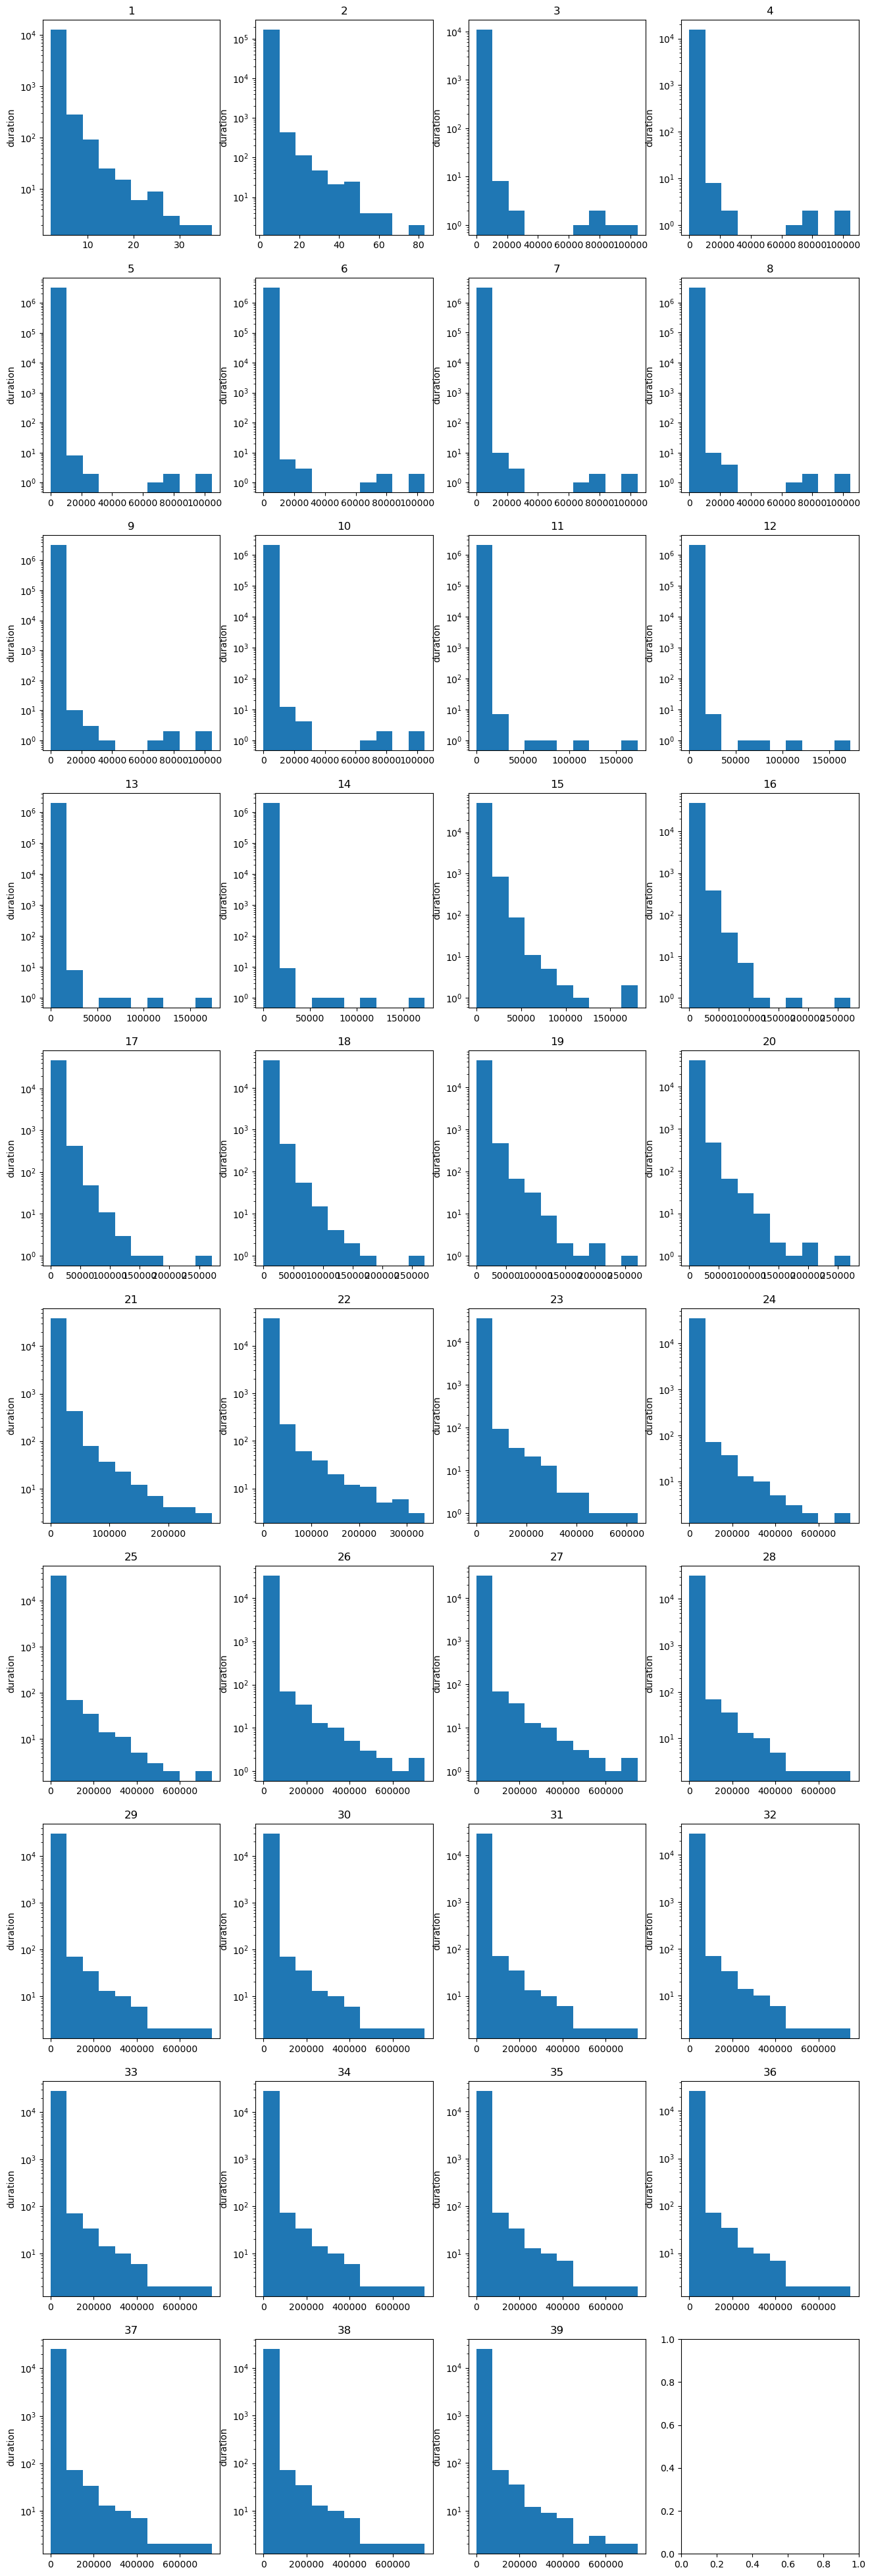

In [26]:
ylabel = 'duration'
miniHistograms(dataod, ylabel)

In [27]:
#something doesn't make sense theres like a 27 hour section where all the datapoints
    #are less than 4 seconds, BUT there's an even longer length portion for 11 seconds?
    # they should be monotonically decreasing
    # ahh jk they should be monotonically incresing, and they are

#I'm going to do some analysis on the max length intervals
    #and the average length interval
    #and the toal amount of time grouped

total_durations = [sum(dataod[key]) for key in dataod]
longest_durations = [max(dataod[key]) for key in dataod]
average_durations = [sum(dataod[key]) / len(dataod[key]) for key in dataod]

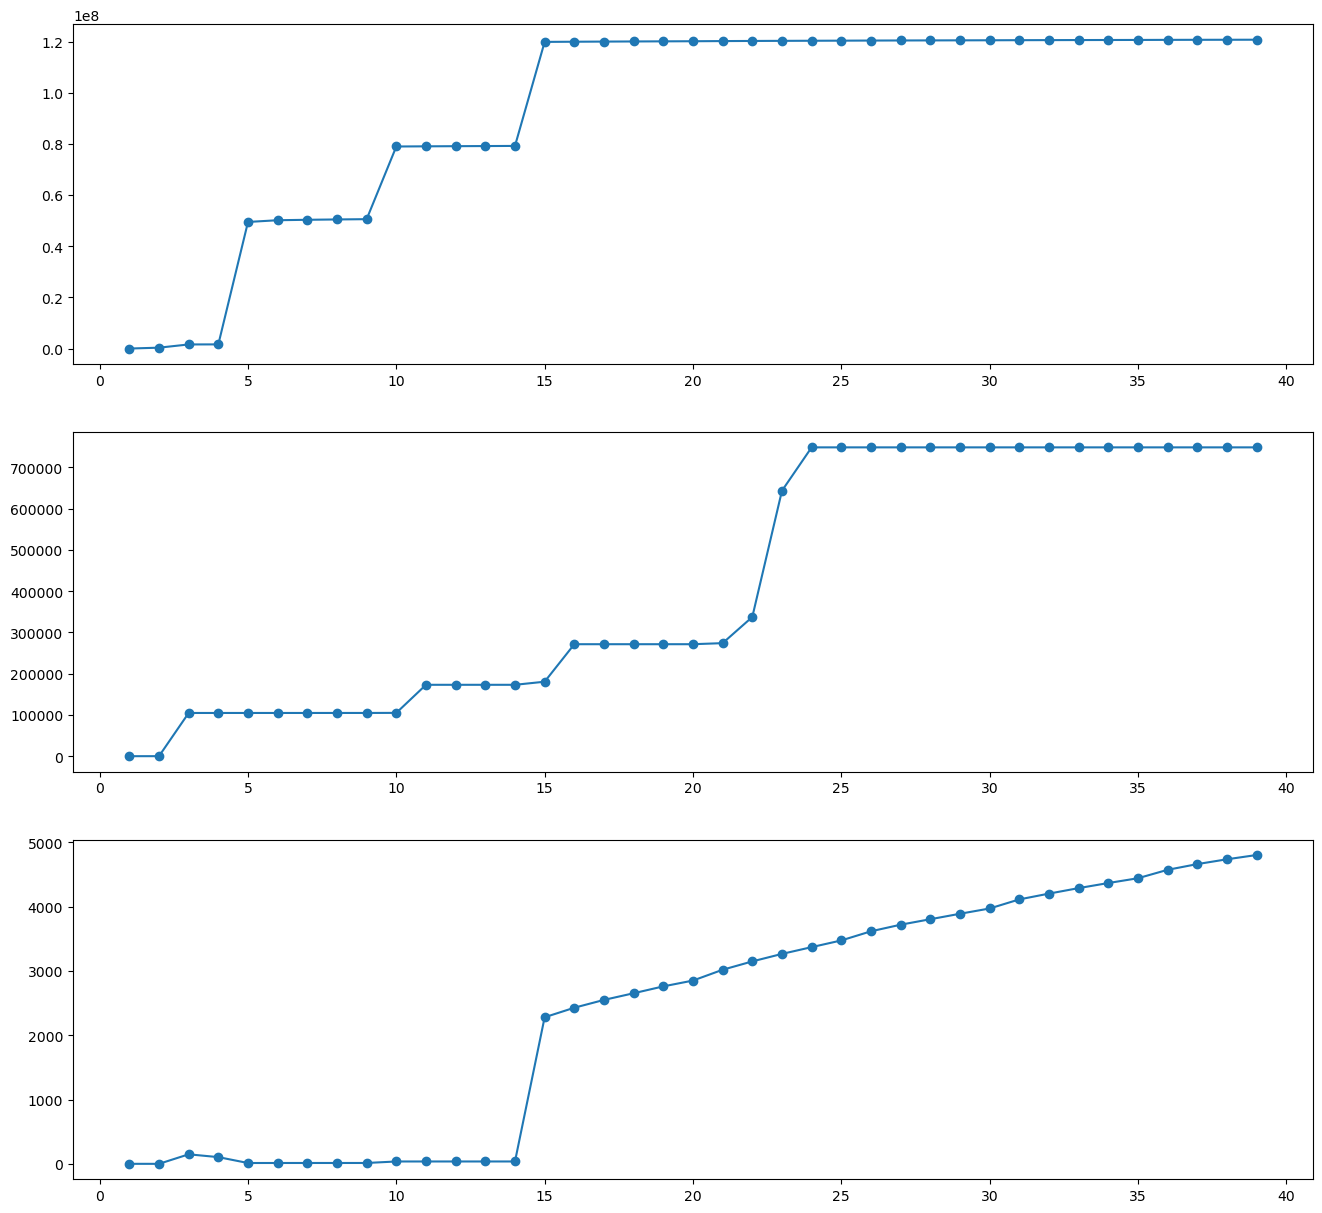

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(16, 15))
axs[0].plot(list(dataod.keys()), total_durations, marker='o')
axs[1].plot(list(dataod.keys()), longest_durations, marker='o')
axs[2].plot(list(dataod.keys()), average_durations, marker='o')

In [ ]:
# also an average confidence based on time of day would be cool